In [7]:
# !pip install seaborn

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34


In [9]:
# pfcn_small.npz에서 train_images, test_images, train_mattes, test_mattes를 np array로 로드하세요.
pfcn_small = np.load('C:\data\pfcn\pfcn_small.npz')
list(pfcn_small)

['train_images', 'test_images', 'train_mattes', 'test_mattes']

In [10]:
train_images = pfcn_small['train_images']
train_mattes = pfcn_small['train_mattes']
test_images = pfcn_small['test_images']
test_mattes = pfcn_small['test_mattes']

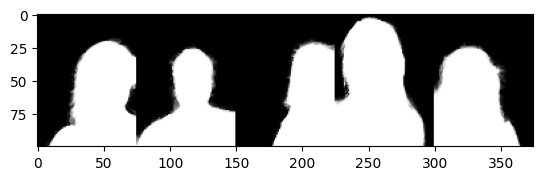

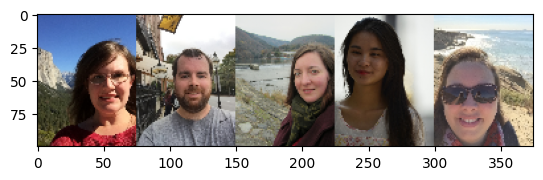

In [11]:
plt.imshow(np.hstack(train_mattes[:5]),cmap='gray')
plt.show()
    
plt.imshow(np.hstack(train_images[:5]))
plt.show()

In [12]:
print(np.shape(train_mattes))
print(np.shape(train_images))

print(np.shape(test_mattes))
print(np.shape(test_images))

(1700, 100, 75)
(1700, 100, 75, 3)
(300, 100, 75)
(300, 100, 75, 3)


In [13]:

print(train_images.max(), train_images.min())
print(test_images.max(), test_images.min())

1.0 0.0
1.0 0.0


In [14]:
train_mattes =np.expand_dims(train_mattes,axis=3)
test_mattes=np.expand_dims(test_mattes,axis=3)
train_mattes.shape, test_mattes.shape

((1700, 100, 75, 1), (300, 100, 75, 1))

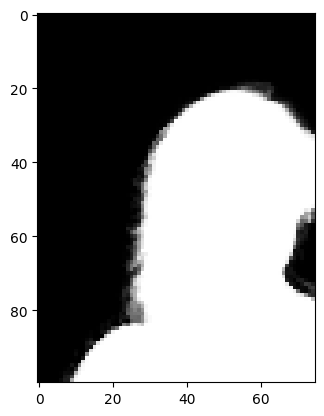

In [15]:
plt.imshow(train_mattes[0].reshape(100,75),cmap='gray')

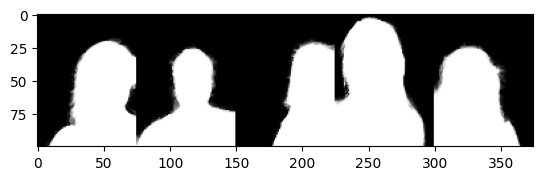

In [16]:
plt.imshow(train_mattes[:5].transpose([1, 0, 2, 3]).reshape((100, -1)), cmap="gray")
plt.show()

## AE 모델링

In [17]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, UpSampling2D, Flatten, Reshape
from keras.models import Model

def ae_like():
  inputs = Input((100, 75, 3))
  x = Conv2D(32, 3, 2, activation='relu', padding='same')(inputs)
  x = Conv2D(64, 3, 2, activation='relu', padding='same')(x)
  x = Conv2D(128, 3, 2, activation='relu', padding='same')(x)
  x = Flatten()(x)
  latent = Dense(10)(x)

  x = Dense((13 * 10 * 128))(latent)
  x = Reshape((13, 10, 128))(x)

  x = UpSampling2D(size = (2,2))(x)
  x = Conv2D(128, (2,2), (1,1), activation='relu', padding='valid')(x)
  
  x = UpSampling2D(size = (2,2))(x)
  x = Conv2D(64, (1,1), (1,1), activation='relu', padding='valid')(x)

  x = UpSampling2D(size = (2,2))(x)
  x = Conv2D(32, (1,2), (1,1), activation='relu', padding='valid')(x)

  x = Conv2D(1, (1,1), (1,1), activation='sigmoid')(x)


  model = Model(inputs, x)
  return model

In [18]:
model = ae_like()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 75, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 50, 38, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 19, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 10, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 16640)             0         
                                                                 
 dense (Dense)               (None, 10)                166410    
                                                                 
 dense_1 (Dense)             (None, 16640)             183040

In [19]:
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [20]:
hist = model.fit(train_images, train_mattes, validation_data=(test_images, test_mattes), epochs=25, verbose=1)

Epoch 1/25
54/54 [==============================] - 8s 35ms/step - loss: 0.1428 - accuracy: 0.7475 - val_loss: 0.1278 - val_accuracy: 0.7621
Epoch 2/25
54/54 [==============================] - 1s 18ms/step - loss: 0.1263 - accuracy: 0.7629 - val_loss: 0.1231 - val_accuracy: 0.7621
Epoch 3/25
54/54 [==============================] - 1s 18ms/step - loss: 0.1209 - accuracy: 0.7673 - val_loss: 0.1076 - val_accuracy: 0.7814
Epoch 4/25
54/54 [==============================] - 1s 17ms/step - loss: 0.0968 - accuracy: 0.8021 - val_loss: 0.0935 - val_accuracy: 0.8042
Epoch 5/25
54/54 [==============================] - 1s 17ms/step - loss: 0.0885 - accuracy: 0.8141 - val_loss: 0.0853 - val_accuracy: 0.8159
Epoch 6/25
54/54 [==============================] - 1s 18ms/step - loss: 0.0815 - accuracy: 0.8233 - val_loss: 0.0798 - val_accuracy: 0.8231
Epoch 7/25
54/54 [==============================] - 1s 18ms/step - loss: 0.0760 - accuracy: 0.8311 - val_loss: 0.0780 - val_accuracy: 0.8254
Epoch 8/25
54

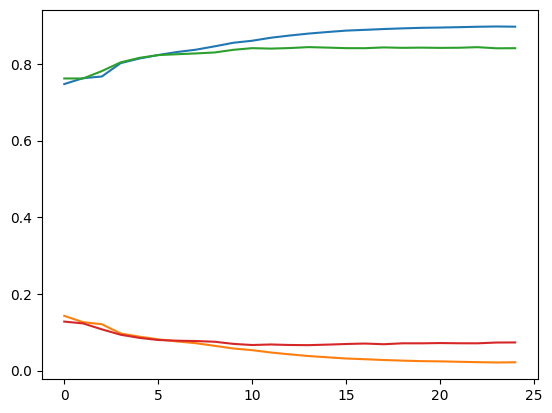

In [22]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label = "accuracy")
plt.plot(hist.history['loss'], label = "loss")
plt.plot(hist.history['val_accuracy'], label = "val_accuracy")
plt.plot(hist.history['val_loss'], label = "val_loss")
# plt.legend(loc = "uppder left")
plt.show()

In [23]:

res = model.predict( test_images[0:1] )

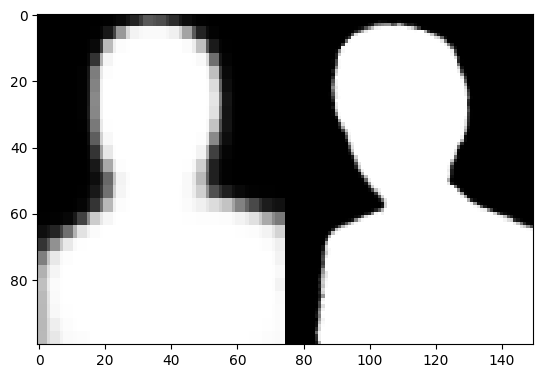

In [24]:
plt.imshow( np.concatenate([res[0], test_mattes[0]]).reshape((2, -1, 75, 1)).transpose([1, 0, 2, 3]).reshape((100, -1)), cmap="gray") 
plt.show()

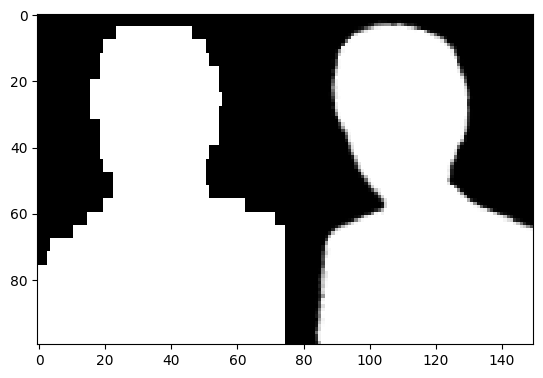

In [25]:
# res를 0.5기준으로 0,1의 값으로 이원화 시켜서 경계영역을 좀더 명확하게 함
plt.imshow( np.concatenate([(res[0] > 0.5).astype(np.float64), test_mattes[0]]).reshape((2, -1, 75, 1)).transpose([1, 0, 2, 3]).reshape((100, -1)), cmap="gray") 
plt.show()

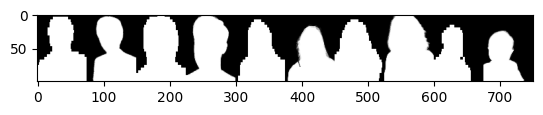

In [26]:

five = (model.predict(test_images[:5]) > 0.5).astype(np.float64)
plt.imshow( np.concatenate([five , test_mattes[:5]], axis=2).transpose((1, 0, 2, 3)).reshape(100, -1) , cmap="gray") 
plt.show()


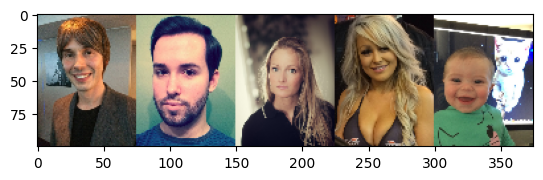

In [27]:
plt.imshow(test_images[:5].transpose((1, 0, 2, 3)).reshape((100, -1, 3))) 
plt.show()

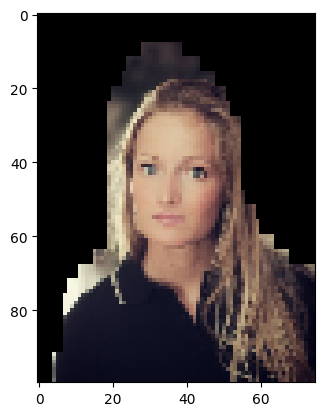

In [28]:
# 예측 이미지와 원본이미지를 곱하여 배경을 지움

plt.imshow ( five[2].reshape((100, 75, 1)) * test_images[2]  )
plt.show()

##  U-net 모델링

In [29]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, MaxPool2D, concatenate

def conv2d_block(x, channel):
  x = Conv2D(channel, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(channel, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

def unet_like():
  inputs = Input((100, 75, 3))

  c1 = conv2d_block(inputs, 16)
  p1 = MaxPool2D((2,2))(c1)
  p1 = Dropout(0.1)(p1)

  c2 = conv2d_block(p1, 32)
  p2 = MaxPool2D((2,2))(c2)
  p2 = Dropout(0.1)(p2)

  c3 = conv2d_block(p2, 64)
  p3 = MaxPool2D((2,2))(c3)
  p3 = Dropout(0.1)(p3)

  c4 = conv2d_block(p3, 128)
  p4 = MaxPool2D((2,2))(c4)
  p4 = Dropout(0.1)(p4)

  c5 = conv2d_block(p4, 256)

  u6 = Conv2DTranspose(128, 2, 2, output_padding=(0,1))(c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(0.1)(u6)
  c6 = conv2d_block(u6, 128)

  u7 = Conv2DTranspose(64, 2, 2, output_padding=(1,0))(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(0.1)(u7)
  c7 = conv2d_block(u7, 64)

  u8 = Conv2DTranspose(32, 2, 2, output_padding=(0,1))(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(0.1)(u8)
  c8 = conv2d_block(u8, 32)

  u9 = Conv2DTranspose(16, 2, 2, output_padding=(0,1))(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(0.1)(u9)
  c9 = conv2d_block(u9, 16)

  outputs = Conv2D(1, (1,1), activation="sigmoid")(c9)

  model = Model(inputs, outputs)
  return model

In [30]:
# unet_like() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.
model = unet_like()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 75, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_7 (Conv2D)              (None, 100, 75, 16)  448         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 75, 16)  64         ['conv2d_7[0][0]']               
 alization)                                                                                       
                                                                                            

In [31]:

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [32]:

hist = model.fit(train_images, train_mattes, validation_data=(test_images, test_mattes), epochs=25, verbose=1)

Epoch 1/25
54/54 [==============================] - 6s 62ms/step - loss: 0.1253 - accuracy: 0.7647 - val_loss: 0.1462 - val_accuracy: 0.7443
Epoch 2/25
54/54 [==============================] - 2s 38ms/step - loss: 0.0635 - accuracy: 0.8537 - val_loss: 0.1695 - val_accuracy: 0.7021
Epoch 3/25
54/54 [==============================] - 2s 37ms/step - loss: 0.0513 - accuracy: 0.8642 - val_loss: 0.1340 - val_accuracy: 0.7594
Epoch 4/25
54/54 [==============================] - 2s 38ms/step - loss: 0.0431 - accuracy: 0.8718 - val_loss: 0.1474 - val_accuracy: 0.7471
Epoch 5/25
54/54 [==============================] - 2s 38ms/step - loss: 0.0373 - accuracy: 0.8773 - val_loss: 0.1006 - val_accuracy: 0.7997
Epoch 6/25
54/54 [==============================] - 2s 38ms/step - loss: 0.0311 - accuracy: 0.8840 - val_loss: 0.0763 - val_accuracy: 0.8301
Epoch 7/25
54/54 [==============================] - 2s 37ms/step - loss: 0.0304 - accuracy: 0.8838 - val_loss: 0.0845 - val_accuracy: 0.8238
Epoch 8/25
54

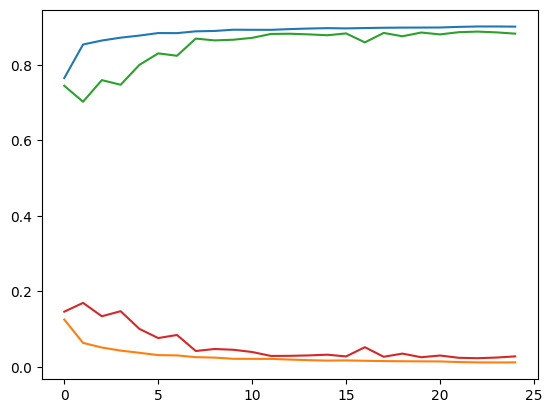

In [34]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label = "accuracy")
plt.plot(hist.history['loss'], label = "loss")
plt.plot(hist.history['val_accuracy'], label = "val_accuracy")
plt.plot(hist.history['val_loss'], label = "val_loss")
# plt.legend(loc = "uppder left")
plt.show()

In [35]:
loss, acc = model.evaluate(test_images, test_mattes, verbose=1)
print(loss, acc)

10/10 [==============================] - 0s 12ms/step - loss: 0.0278 - accuracy: 0.8824
0.02781360037624836 0.8824040293693542


In [36]:

res = model.predict( test_images[2:3] )

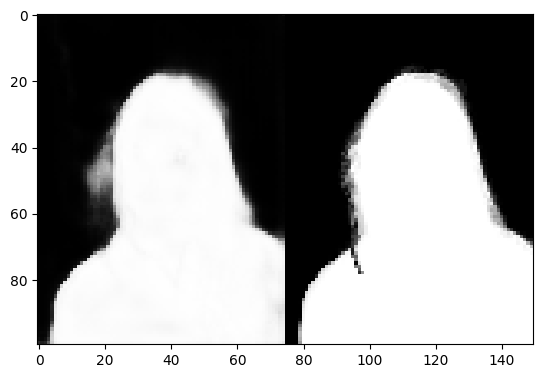

In [37]:
imgs = np.concatenate([res.reshape((100, 75, 1)), test_mattes[2]]).reshape((2, -1, 75, 1)).transpose((1,0, 2, 3)).reshape((100, -1))
plt.imshow(imgs, cmap="gray")
plt.show()

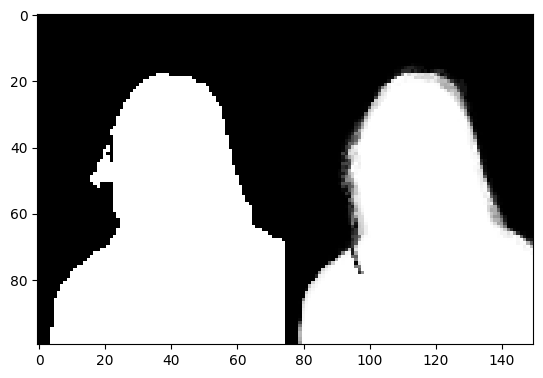

In [38]:

imgs = np.concatenate([(res > 0.5).astype(np.float64).reshape((100, 75, 1)), test_mattes[2] ]).reshape((2, -1, 75, 1)).transpose((1,0, 2, 3)).reshape((100, -1))
plt.imshow(imgs, cmap="gray")
plt.show()


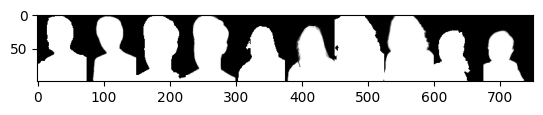

In [39]:

five = (model.predict(test_images[:5]) > 0.5).astype(np.float64)
plt.imshow( np.concatenate([five , test_mattes[:5]], axis=2).transpose((1, 0, 2, 3)).reshape(100, -1) , cmap="gray") 
plt.show()

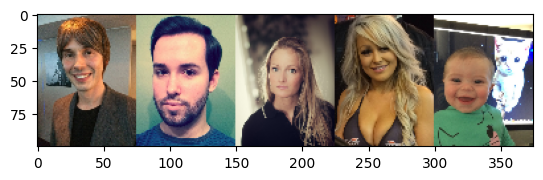

In [40]:
plt.imshow(test_images[:5].transpose((1,0, 2, 3)).reshape((100, -1, 3)))
plt.show()

In [280]:
# 아래와 같이 나오는게 목적임(제공되는 배경제거 자료와 매칭한 자료임)
# plt.imshow(test_images[4] * test_mattes[4].reshape((100, 75 ,1)))
masked = test_images[4] * test_mattes[4]
import cv2
_,alpha = cv2.threshold(masked,0,255,cv2.THRESH_BINARY)
b, g, r = cv2.split(masked)
# alpha = np.array(alpha).astype('uint8')
alpha = alpha.mean(axis=-1, keepdims=True)
img = cv2.merge([b,g,r, alpha], 4)
# cv2.imwrite('C:\data\pfcn\save3.png', img)


AttributeError: 'numpy.ndarray' object has no attribute 'read'

In [74]:
import cv2
import numpy as np

# img = cv2.imread("image.png", cv2.IMREAD_UNCHANGED)
img = test_images[4] * test_mattes[4]
# img[np.where(np.all(img[..., :3] == 255, -1))] = 0
# cv2.imwrite("transparent.png", img)
np.shape(img)


AttributeError: 'numpy.ndarray' object has no attribute 'convert'

In [48]:
# plt.imshow(test_mattes[4])

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]]])

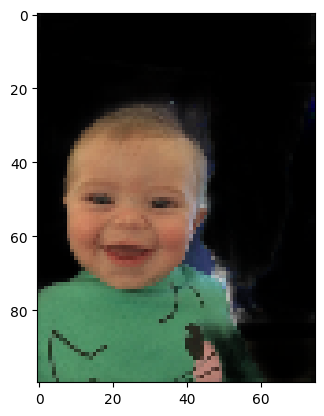

In [42]:
# 딥러닝 모델임
plt.imshow(test_images[4] * model.predict(test_images[4:5]).reshape((100, 75 ,1)))
plt.show()

In [43]:
# 모델을 저장하는 코드를 작성하세요.
model.save("C:\data\pfcn\배경제거.h5")